## make_sbc:
### Make surface boundary conditions.
#### Version id:
#### v1.
#### Tamura fluxes and ERA_interim

In [1]:
run ='amery_v2km'

import numpy as np 
import os
import sys
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import griddata


proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)


from ext.tools.NDinterp import NDinterp
from ext.tools.log_progress import log_progress

# set paths

T_mask_path = os.path.join(data_dir,'raw','tamura','EASE_landmask_H.data')
T_lat_lon_path = os.path.join(data_dir,'raw','tamura','EASE_latlon_H.data')
T_data_path = os.path.join(data_dir,'raw','tamura')
era_path = os.path.join(data_dir,'raw','era_interim','ERA_Interim_1992_2011.2daily.*winds.nc')
R_grid_path = os.path.join(data_dir,'proc',run+'_v12_grd.nc')

In [2]:
#load roms grid and convert lon to 0-360

R_grid = xr.open_dataset(R_grid_path)
R_lon = R_grid.lon_rho.values
R_lat = R_grid.lat_rho.values
R_angle = R_grid.angle.values
R_ulon = R_grid.lon_u.values
R_vlon = R_grid.lon_v.values
R_ulat = R_grid.lat_u.values
R_vlat = R_grid.lat_v.values


R_lon[R_lon<0]+=360
R_ulon[R_ulon<0]+=360
R_vlon[R_vlon<0]+=360

In [3]:
#read in tamura land mask
with open(T_mask_path,'rb') as fid:
    T_mask = np.fromfile(fid,count=(721*721),dtype='float32').reshape((721,721))
    T_mask = np.flipud(T_mask)

In [4]:
#get tamura lat lon coordinates
with open(T_lat_lon_path,'rb') as fid:
    T_lat_lon = np.fromfile(fid,count=(721*721*2),dtype='float32').reshape((2,721,721))
T_lat,T_lon = (T_lat_lon[0],T_lat_lon[1])
T_lat = np.flipud(T_lat)
T_lon = np.flipud(T_lon)
T_lon[T_lon<0]+=360

In [5]:
#read in era interim winds and resample from twice daily to daily
era_ds = xr.open_mfdataset(era_path,data_vars='minimal').sel(time='2007',latitude=slice(-30,-90)).resample(time='D').mean()

#get era coordinates
era_lon,era_lat = era_ds.longitude.values,era_ds.latitude.values
era_lon_2d,era_lat_2d = np.meshgrid(era_lon,era_lat)

In [6]:
#define regridding functions for era and tamura data
# griddata takes flat arrays of source points and data and interpolates to 2d grid
        

def regrid_tamura(slon,slat,sdat,tlon,tlat):
    
    slon = slon[slat<(tlat.max()+2)] # only load data up to 2 deg further north of roms highest latitude
    sdat = sdat[slat<(tlat.max()+2)]
    slat = slat[slat<(tlat.max()+2)]
    
    #tamura comes from npstereo curvilinear grid
    #we need to find points close to the 0/360 gap, wrap them and add them to the list for source points
    # otherwise we get an interpolation gap between 0/360
    
    ii1 = (slon<2.0)

    slon_ext1 = slon[ii1]
    slon_ext1[slon_ext1<=1]+=360

    ii2 = (slon>358.0)

    slon_ext2 = slon[ii2]
    slon_ext2[slon_ext2>=359]-=360
    
    slon_ext = np.hstack((slon_ext1,slon_ext2))
    slat_ext = np.hstack((slat[ii1],slat[ii2]))
    sdat_ext = np.hstack((sdat[ii1],sdat[ii2]))
      
    slon = np.hstack((slon,slon_ext))
    slat = np.hstack((slat,slat_ext))
    sdat = np.hstack((sdat,sdat_ext))

    tdat =griddata((slon,slat),sdat,(tlon,tlat),'cubic')
    
    return tdat

In [7]:
# define inpaint_nans
from scipy.signal import convolve2d
def inpaint_nans(inField):
    im = inField.copy()
    import scipy
    ipn_kernel = np.array([[1,1,1],[1,0,1],[1,1,1]]) # kernel for inpaint_nans
    nans = np.isnan(im)
    while np.sum(nans)>0:
        im[nans] = 0
        vNeighbors = convolve2d((nans==False),ipn_kernel,mode='same',boundary='symm')
        im2 = convolve2d(im,ipn_kernel,mode='same',boundary='symm')
        im2[vNeighbors>0] = im2[vNeighbors>0]/vNeighbors[vNeighbors>0]
        im2[vNeighbors==0] = np.nan
        im2[(nans==False)] = im[(nans==False)]
        im = im2
        nans = np.isnan(im)
    return im


In [8]:
# era is more easy, since its on a mercator projection
# we just have to extend the arrays at the beginning and end to bridge the gap at 0/360

def regrid_era(slon_raw,slat,sdat_raw,tlon,tlat):
    
    slon = np.zeros(np.size(slon_raw)+2)
    slon[0] = slon_raw[-1]-360
    slon[1:-1] = slon_raw[:]
    slon[-1] = slon_raw[0]+360

    slon, slat = np.meshgrid(slon,slat)
    
    sdat = np.zeros((np.size(sdat_raw,0),np.size(sdat_raw,1)+2))
    sdat[:,0] = sdat_raw[:,-1]
    sdat[:,1:-1] = sdat_raw[:,:]
    sdat[:,-1] = sdat_raw[:,0]
    
    slon = slon[slat<(tlat.max()+2)]
    sdat = sdat[slat<(tlat.max()+2)]
    slat = slat[slat<(tlat.max()+2)]

    tdat =griddata((slon,slat),sdat,(tlon,tlat),'cubic')
        
    return tdat

In [9]:
#preload the datasets so they're not loaded each loop
era_ds.load()
R_grid.load()


<xarray.Dataset>
Dimensions:    (eta_rho: 750, xi_rho: 900, eta_psi: 749, xi_psi: 899,
                eta_u: 750, xi_u: 899, eta_v: 749, xi_v: 900)
Dimensions without coordinates: eta_rho, xi_rho, eta_psi, xi_psi, eta_u, xi_u,
                                eta_v, xi_v
Data variables: (12/31)
    spherical  <U3 '"T"'
    xl         float64 1.776e+06
    el         float64 1.507e+06
    angle      (eta_rho, xi_rho) float64 1.57 1.57 1.57 ... 1.144 1.144 1.144
    pm         (eta_rho, xi_rho) float64 0.0004954 0.0004954 ... 0.0005286
    pn         (eta_rho, xi_rho) float64 0.0004956 0.0004956 ... 0.0005293
    ...         ...
    x_v        (eta_v, xi_v) float64 1.501e+06 1.503e+06 ... 3.297e+06 3.299e+06
    y_v        (eta_v, xi_v) float64 2e+03 2e+03 2e+03 ... 1.498e+06 1.498e+06
    mask_rho   (eta_rho, xi_rho) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_psi   (eta_psi, xi_psi) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_u     (eta_u, xi_u) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    mask_v     (eta_v, xi_v) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    history:  GRID file using make_grid.py,2024-03-14
    type:     ROMS grid file

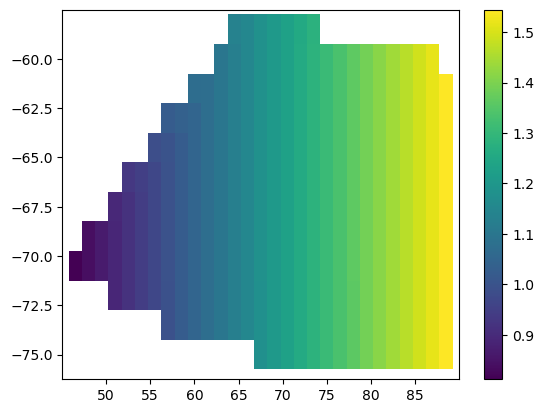

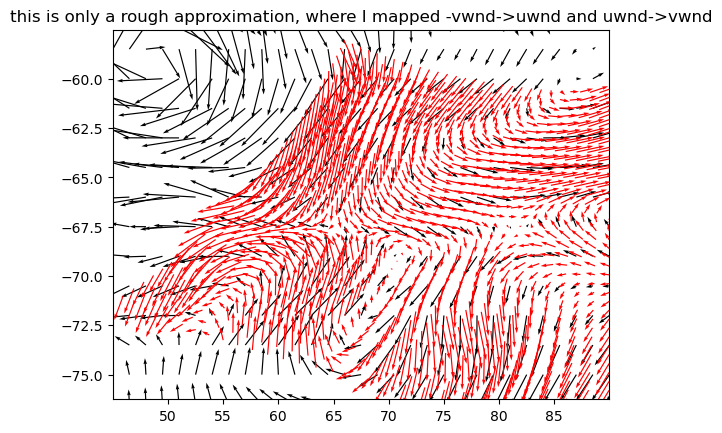

(1413500.000676553, 3338500.001665637, -71499.99973461866, 1523500.0012100537)

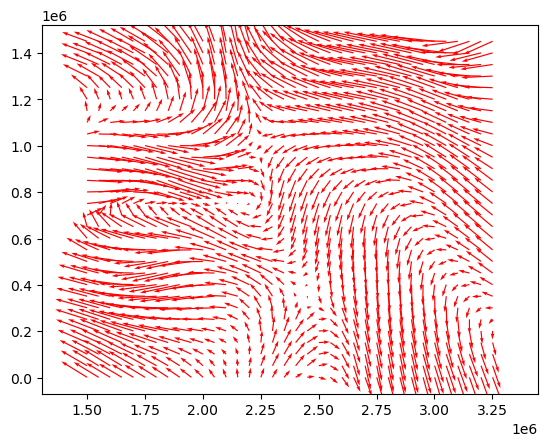

In [10]:
## Test wind rotation
### Do a quick test to see how the winds are rotated. Note that if the model is on a PS grid,
### then the plot of the rotated grids should be against the model x,y coordinates

R_angle_to_Src = griddata((R_lon.flatten(),R_lat.flatten()),R_angle.flatten(),(era_lon_2d,era_lat_2d),'cubic')

plt.pcolormesh(era_lon_2d,era_lat_2d,R_angle_to_Src)
plt.axis((R_lon.min(),R_lon.max(),R_lat.min(),R_lat.max()))
plt.colorbar()
plt.show()
plt.pcolormesh(R_lon,R_lat,R_angle)
plt.axis((R_lon.min(),R_lon.max(),R_lat.min(),R_lat.max()))
plt.colorbar()

Eidx=0
uwnd = era_ds.u10[Eidx].values
vwnd = era_ds.v10[Eidx].values
uv = (uwnd+1j*vwnd)*np.exp(-1j*(R_angle_to_Src)) 
uwnd = np.real(uv)
vwnd = np.imag(uv)

uwnd = inpaint_nans(uwnd).copy()
vwnd = inpaint_nans(vwnd).copy()

uwnd_rho = regrid_era(era_lon,era_lat,uwnd,R_lon,R_lat)
vwnd_rho = regrid_era(era_lon,era_lat,vwnd,R_lon,R_lat)


uwnd = regrid_era(era_lon,era_lat,uwnd,R_ulon,R_ulat)
vwnd = regrid_era(era_lon,era_lat,vwnd,R_vlon,R_vlat)

#convert to stress
signu = np.sign(uwnd)
signv = np.sign(vwnd)

rhoAir = 1.3
Cd = 1.4e-3

taux = rhoAir*Cd*np.square(uwnd)*signu
tauy = rhoAir*Cd*np.square(vwnd)*signv

taux_rho = rhoAir*Cd*np.square(uwnd_rho)*np.sign(uwnd_rho)
tauy_rho = rhoAir*Cd*np.square(vwnd_rho)*np.sign(vwnd_rho)


plt.pcolormesh(R_ulon,R_ulat,taux,vmin=-.1,vmax=.1,cmap='RdBu_r')
ca = plt.gca().axis()
plt.colorbar()
plt.close()
# plt.show()
# plt.pcolormesh(era_lon,era_lat,rhoAir*Cd*np.square(era_ds.u10[Eidx].values)*np.sign(era_ds.u10[Eidx].values),vmin=-.1,vmax=.1,cmap='RdBu_r')
# plt.colorbar()
# plt.axis(ca)
# plt.show()
# plt.pcolormesh(era_lon,era_lat,rhoAir*Cd*np.square(era_ds.v10[Eidx].values)*np.sign(era_ds.v10[Eidx].values),vmin=-.1,vmax=.1,cmap='RdBu_r')
# plt.colorbar()
# plt.axis(ca)
# plt.show()


# plt.quiver(era_lon,era_lat,era_ds.u10[Eidx].values,era_ds.v10[Eidx].values,scale=100)
# plt.axis(ca)
# plt.show()


# plt.pcolormesh(taux,vmin=-.1,vmax=.1,cmap='RdBu_r')
# # plt.axis(ca)
# plt.colorbar()
# plt.show()
# plt.pcolormesh(tauy,vmin=-.1,vmax=.1,cmap='RdBu_r')
# plt.colorbar()


# plt.quiver(R_lon[0:-1:25,0:-1:25],R_lat[0:-1:25,0:-1:25],uwnd_rho[0:-1:25,0:-1:25],vwnd_rho[0:-1:25,0:-1:25],scale=100)
# plt.axis(ca)
# plt.show()

# plt.show()
plt.quiver(era_lon,era_lat,era_ds.u10[Eidx].values,era_ds.v10[Eidx].values,scale=100)
plt.quiver(R_lon[0:-1:25,0:-1:25],R_lat[0:-1:25,0:-1:25],-vwnd_rho[0:-1:25,0:-1:25],uwnd_rho[0:-1:25,0:-1:25],scale=100,color='r')
plt.title('this is only a rough approximation, where I mapped -vwnd->uwnd and uwnd->vwnd')
plt.axis(ca)
plt.show()

# plt.quiver(era_lon,era_lat,era_ds.u10[Eidx].values,era_ds.v10[Eidx].values,scale=100)
# plt.streamplot(era_lon_2d, np.flipud(era_lat_2d), np.flipud(era_ds.u10[Eidx].values),np.flipud(era_ds.v10[Eidx].values),density=4)
plt.quiver(R_grid.x_rho[0:-1:25,0:-1:25], R_grid.y_rho[0:-1:25,0:-1:25], uwnd_rho[0:-1:25,0:-1:25],vwnd_rho[0:-1:25,0:-1:25],scale=100,color='r')
plt.axis('equal')
# plt.axis(ca)

# plt.show()

# # plt.quiver(R_lon[0:-1:25,0:-1:25],R_lat[0:-1:25,0:-1:25],uwnd_rho[0:-1:25,0:-1:25],vwnd_rho[0:-1:25,0:-1:25],scale=100,color='r')
# plt.streamplot(R_lon.T, R_lat.T, uwnd_rho,vwnd_rho)
# plt.axis(ca)

In [11]:
# MAKE THE MAGIC HAPPEN FOR 2007 AND save in interim folder
month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
month_nb = ['01','02','03','04','05','06','07','08','09','10','11','12']
daysPerMonth = [31,28,31,30,31,30,31,31,30,31,30,31]

#month = ['nov']
#month_nb = ['11']
#daysPerMonth = [30]

#month = ['jan']
#
#daysPerMonth = [1]


#interpolate the ROMS grid angle to the source grid:
R_angle_to_Src = griddata((R_lon.flatten(),R_lat.flatten()),R_angle.flatten(),(era_lon_2d,era_lat_2d),'cubic')


dayOfYear = 1

for month,days,month_nb in zip(month,daysPerMonth,month_nb):
    
    print('Processing month: ',month,'with days: ',days)
    
    daysOfYear = np.arange(dayOfYear,dayOfYear+days,dtype=int)
    
    print('Containing days of year: ',daysOfYear)

    # preparing empty dataset
    ds = xr.Dataset({'shflux':(['shf_time','eta_rho','xi_rho'], np.empty((days,R_grid.eta_rho.size,R_grid.xi_rho.size))),
                     'swflux':(['swf_time','eta_rho','xi_rho'], np.empty((days,R_grid.eta_rho.size,R_grid.xi_rho.size))),
                     'sustr':(['sms_time','eta_u','xi_u'], np.empty((days,R_grid.eta_u.size,R_grid.xi_u.size))),
                     'svstr':(['sms_time','eta_v','xi_v'], np.empty((days,R_grid.eta_v.size,R_grid.xi_v.size)))},
                   coords={'shf_time':(['shf_time'],daysOfYear),
                           'swf_time':(['swf_time'],daysOfYear),
                           'sms_time':(['sms_time'],daysOfYear)})
   
    #open Tamura month flux data 
    T_month_path = os.path.join(T_data_path,'TSDM2hb_2007_'+month+'.data')
    with open(T_month_path,'rb') as fid:
        T_data = np.swapaxes(np.fromfile(fid,count = days*6*721*721 ,dtype='float32').reshape(days,6,721,721),0,1)
    
    #looping over the days with running day-of-the-year and day-of-the-month index
    for Eidx,Tidx in zip(log_progress(daysOfYear-1,name='days'),np.arange(days)):
        
        #read in Tamura heat and fresh water flux and turn in right position
        shflux_tmp = np.flipud(T_data[0,Tidx])
        ssflux_tmp = np.flipud(T_data[2,Tidx])
        
        #fill in tamuar mask for later resampling
        shflux_tmp[T_mask==0] = np.nan
        shflux_tmp = NDinterp(shflux_tmp)
        
        ssflux_tmp[T_mask==0] = np.nan
        ssflux_tmp = NDinterp(ssflux_tmp)
        
        shflux_tmp = regrid_tamura(T_lon,T_lat,shflux_tmp,R_lon,R_lat) 
        ssflux_tmp = regrid_tamura(T_lon,T_lat,ssflux_tmp,R_lon,R_lat)
        
        shflux_tmp[shflux_tmp > 0.0]*=0.5
        
        ds.shflux[Tidx] = shflux_tmp
        del shflux_tmp
        
        #convert to freshwater flux with convention positive up 'swf (E-P)',
        #that means a positive freshwater flux value results in positive salt flux value
        #and save to dataset
        refSalt = 34.4
        # original units of ssflux has units of Salt*[E-P] [m/day]
        # So to convert to correct units [m/s], need to multiply by 1/86400, as 1/86400 days per second,
        # # to go from 1/day to 1/s
        
        ds.swflux[Tidx] = ssflux_tmp/refSalt*100 * 0.01/86400 
        del ssflux_tmp
        
        #select era-interim winds
        uwnd = era_ds.u10[Eidx].values
        vwnd = era_ds.v10[Eidx].values
        
               
        #rotate wind directions to roms grid
        # uv = (taux+1j*tauy)*np.exp(1j*-(u_lon_2d/180*np.pi)) # note that lon/180*pi is an incorrect approximation to the grid angle
                                                                # also, this is using the rotation angle of the forcing product grid, 
                                                                # not the rotation angle of the roms grid
                # from "./examples/Arctic_SODA3.3.1/remap_bdry_uv.py" in pyroms_toolbox
                # angle = dst_angle-src_angle. #src_angle assumed to be 0 (unrotated lat/lon grid == true).
                # rotated angles are then:
                    # U_north = dst_u_north + dst_v_north*1j
                    # eitheta_north = np.exp(-1j*angle[:,Mp-2:Mp, 0:Lp])
                    # U_north = U_north * eitheta_north
                    # dst_u_north = np.real(U_north)
                    # dst_v_north = np.imag(U_north)

        uv = (uwnd+1j*vwnd)*np.exp(-1j*(R_angle_to_Src)) 
        uwnd = uv.real
        vwnd = uv.imag
        
        uwnd = inpaint_nans(uwnd)
        vwnd = inpaint_nans(vwnd)
        
        uwnd = regrid_era(era_lon,era_lat,uwnd,R_ulon,R_ulat)
        vwnd = regrid_era(era_lon,era_lat,vwnd,R_vlon,R_vlat)
        
        
        #convert to stress
        signu = np.sign(uwnd)
        signv = np.sign(vwnd)

        rhoAir = 1.3
        Cd = 1.4e-3

        taux = rhoAir*Cd*np.square(uwnd)*signu
        tauy = rhoAir*Cd*np.square(vwnd)*signv
        del uwnd, vwnd
        
        ds.sustr[Tidx]= taux#taux_smooth*fac
        ds.svstr[Tidx]= tauy#tauy_smooth*fac
        
        
        del taux, tauy
        
    #add attributes to data set and data arrays
    ds.attrs={'title':'surface heat/fresh water fluxes and wind stress',
                          'date':str(datetime.date.today()),
                          'tamura_file':T_data_path,
                          'era-interim file':era_path,
                          'grid file':R_grid_path,
                          'type':'ROMS forcing file'}
    ds.shflux.attrs = {'long_name': 'surface net heat flux', 'units': 'Watts meter-2'}
    ds.swflux.attrs = {'long_name': 'surface freshwater flux (E-P)',
                       'negative': 'net precipitation',
                       'positive': 'net evaporation',
                       'units': 'metre second-1',
                       '_FillValue':1e+37}
    ds.sustr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.svstr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.sms_time.attrs = {'cycle_length': days,'long_name': 'surface momentum stress time','units': 'day'}
    ds.shf_time.attrs = {'cycle_length': days, 'long_name': 'surface heat flux time', 'units': 'day'}
    ds.swf_time.attrs = {'cycle_length': days,'long_name': 'surface freshwater flux time','units': 'day'}
    
    #save month as netcdf files
    for var,dim in zip(['shflux','swflux','sustr','svstr'],['shf_time','swf_time','sms_time','sms_time']):
        int_path = os.path.join(data_dir,'cache',run+'_'+var+'_'+month_nb+'.nc')
        print("Saving month to "+int_path)
        ds[var].to_netcdf(int_path,'w',unlimited_dims=dim)
    #del ds
    
    #update the day of the year value for next month
    dayOfYear += days

KeyboardInterrupt: 

In [ ]:
#collect all interim results, merge to yearly data amd adjust cycle length attribute
#save forcing files in processed folder
for var,dim in zip(['shflux','swflux','sustr','svstr'],['shf_time','swf_time','sms_time','sms_time']):
    ds = xr.open_mfdataset(os.path.join(data_dir,'cache',run+'_'+var+'_??.nc'))
    ds[dim]
    ds[dim].attrs['cycle_length'] = float(365)
    out_path = os.path.join(data_dir,'proc',run+'_tamura+era_noMack_'+var+'.nc')
    print('saving final to'+out_path)
    ds.to_netcdf(out_path,'w')

saving final to/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_tamura+era_shflux.nc
saving final to/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_tamura+era_swflux.nc
saving final to/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_tamura+era_sustr.nc
saving final to/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_tamura+era_svstr.nc


In [12]:
old_shflux = xr.open_dataset(os.path.join(data_dir,'proc',run+'_tamura+era_'+'shflux.nc'))
old_swflux = xr.open_dataset(os.path.join(data_dir,'proc',run+'_tamura+era_'+'swflux.nc'))

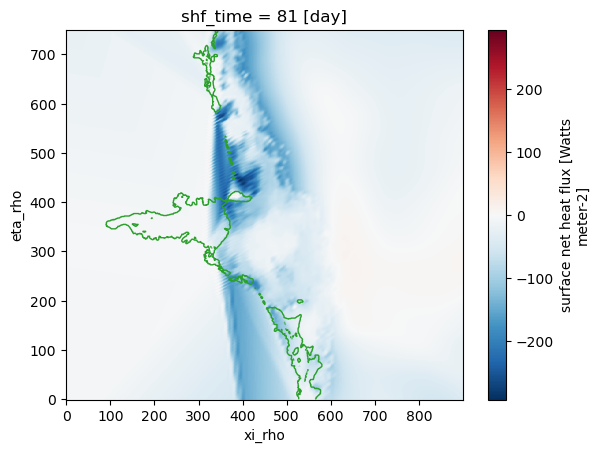

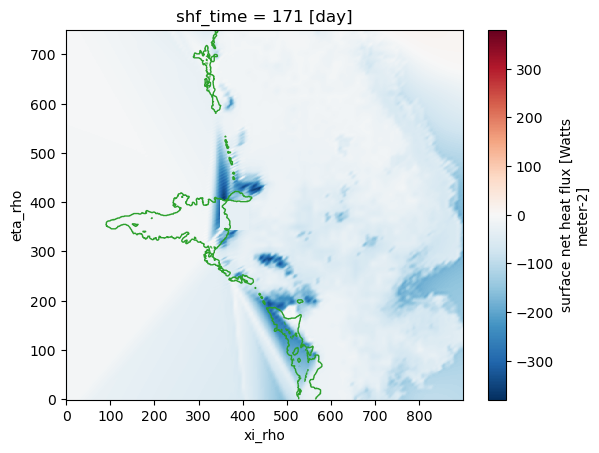

In [13]:
mac_xi=slice(350,415)
mac_eta=slice(345,405)

new_shflux=old_shflux.copy()


old_shflux.shflux.isel(shf_time=80).plot()
co1 = plt.contour(R_grid.zice*R_grid.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
plt.show()
for tt in range(len(new_shflux.shf_time)):
    new_shflux.shflux[tt,mac_eta,mac_xi]=new_shflux.shflux[tt,330,450]

new_shflux.shflux.isel(shf_time=170).plot()
co1 = plt.contour(R_grid.zice*R_grid.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)

# new_shflux.shflux


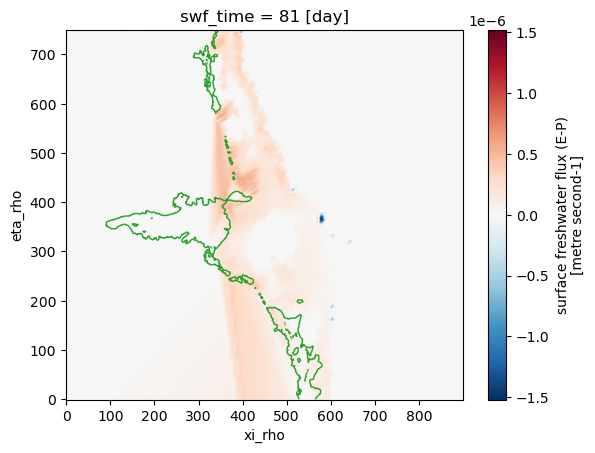

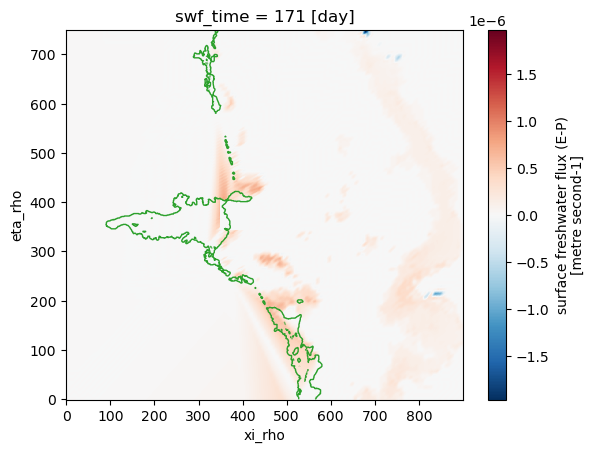

In [14]:
mac_xi=slice(350,415)
mac_eta=slice(345,405)

new_swflux=old_swflux.copy()


old_swflux.swflux.isel(swf_time=80).plot()
co1 = plt.contour(R_grid.zice*R_grid.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
plt.show()
for tt in range(len(new_swflux.swf_time)):
    new_swflux.swflux[tt,mac_eta,mac_xi]=new_swflux.swflux[tt,330,450]

new_swflux.swflux.isel(swf_time=170).plot()
co1 = plt.contour(R_grid.zice*R_grid.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)

# new_shflux.shflux


In [15]:

new_shflux.to_netcdf(os.path.join(data_dir,'proc',run+'_tamura+era_noMack_'+'shflux'+'.nc'),'w')
new_swflux.to_netcdf(os.path.join(data_dir,'proc',run+'_tamura+era_noMack_'+'swflux'+'.nc'),'w')
